In [ ]:
# run the script in the the Google Colab environment
from google.colab import drive
drive.flush_and_unmount()
drive.mount('/content/drive')

import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

Drive not mounted, so nothing to flush and unmount.
Mounted at /content/drive


In [ ]:
# read the data generated by the SQL script
df = pd.read_csv('/content/drive/My Drive/MS-data/Drive/DA205/traveltide-indexes.csv')
df.head()

,user_id,free_hotel_meal_index,avg_checked_bags_index,cancellation_index,bargain_hunter_index,flight_hotel_booked_index
0,23557,0.002747,NaN,0.0,NaN,0.0
1,94883,NaN,0.066176,0.0,NaN,1.0
2,101486,NaN,0.000000,0.0,NaN,0.5
3,101961,NaN,0.132353,0.0,0.000096,1.0
4,106907,NaN,0.661765,0.5,NaN,1.0


In [ ]:
# remove NaN values
df.loc[df['free_hotel_meal_index'].isnull(), "free_hotel_meal_index"] = 0
df.loc[df['avg_checked_bags_index'].isnull(), 'avg_checked_bags_index'] = 0
df.loc[df['cancellation_index'].isnull(), 'cancellation_index'] = 0
df.loc[df['bargain_hunter_index'].isnull(), 'bargain_hunter_index'] = 0
df.loc[df['flight_hotel_booked_index'].isnull(),'flight_hotel_booked_index'] = 0
df.isna().sum()

user_id                      0
free_hotel_meal_index        0
avg_checked_bags_index       0
cancellation_index           0
bargain_hunter_index         0
flight_hotel_booked_index    0
dtype: int64

In [ ]:
df3 = df.copy()

In [ ]:
# Columns to scale
scaleCols = ['free_hotel_meal_index','avg_checked_bags_index','cancellation_index','bargain_hunter_index','flight_hotel_booked_index']

# Create scaler object. Scaling the indexes with prefix "scaled_"
scaler = StandardScaler()
scaleCols_data = scaler.fit_transform(df3[scaleCols])
scaled_Cols = ["scaled_" + col for col in scaleCols]
df3[scaled_Cols] = scaleCols_data.round(4)

# Sampling the data
df3.sample(5)

,user_id,free_hotel_meal_index,avg_checked_bags_index,cancellation_index,bargain_hunter_index,flight_hotel_booked_index,scaled_free_hotel_meal_index,scaled_avg_checked_bags_index,scaled_cancellation_index,scaled_bargain_hunter_index,scaled_flight_hotel_booked_index
4746,583446,0.000000,0.132353,0.0,0.002794,0.75,-0.1482,0.4414,-0.3056,-0.0082,0.2252
4895,589162,0.000387,0.000000,0.0,0.000000,1.00,-0.0535,-0.9762,-0.3056,-0.2092,0.9210
5242,607028,0.000000,0.198529,0.0,0.000361,1.00,-0.1482,1.1502,-0.3056,-0.1832,0.9210
3659,552945,0.000000,0.132353,0.0,0.000581,0.60,-0.1482,0.4414,-0.3056,-0.1674,-0.1923
1865,522062,0.000000,0.132353,0.0,0.000000,0.75,-0.1482,0.4414,-0.3056,-0.2092,0.2252


In [ ]:
# metric indexes ranking
indexes_rank = pd.DataFrame()
indexes_rank['user_id'] = df3['user_id']
indexes_rank.set_index('user_id', inplace=True)
metric_indexes = ['scaled_free_hotel_meal_index','scaled_avg_checked_bags_index','scaled_cancellation_index',
                  'scaled_bargain_hunter_index','scaled_flight_hotel_booked_index']

for metric in metric_indexes:
    metrics_sorted = df3.sort_values(by=[metric], ascending=False).reset_index(drop=True)
    metrics_sorted[f"rank_{metric}"] = metrics_sorted.index + 1   # ranking from 1 to N (number of users in the cohort)
    indexes_rank[f"rank_{metric}"] = metrics_sorted.set_index("user_id")[f"rank_{metric}"]

# reset index of metric indexes
indexes_rank.reset_index(inplace=True)

# check ranking results
indexes_rank.head()

,user_id,rank_scaled_free_hotel_meal_index,rank_scaled_avg_checked_bags_index,rank_scaled_cancellation_index,rank_scaled_bargain_hunter_index,rank_scaled_flight_hotel_booked_index
0,23557,256,4590,1071,3510,5202
1,94883,5966,3684,4976,4897,858
2,101486,3032,5056,4106,4346,4046
3,101961,3022,2161,4105,1678,2090
4,106907,3011,5,87,4345,2088


In [ ]:
# locate the minimum index for each user
indexes_rank['min_index'] = indexes_rank.iloc[:, 1:].idxmin(axis=1).str.replace('rank_', '')

# check search results
indexes_rank.head()

,user_id,rank_scaled_free_hotel_meal_index,rank_scaled_avg_checked_bags_index,rank_scaled_cancellation_index,rank_scaled_bargain_hunter_index,rank_scaled_flight_hotel_booked_index,min_index
0,23557,256,4590,1071,3510,5202,scaled_free_hotel_meal_index
1,94883,5966,3684,4976,4897,858,scaled_flight_hotel_booked_index
2,101486,3032,5056,4106,4346,4046,scaled_free_hotel_meal_index
3,101961,3022,2161,4105,1678,2090,scaled_bargain_hunter_index
4,106907,3011,5,87,4345,2088,scaled_avg_checked_bags_index


In [ ]:
# map corresponding perk to the index
index_perks = {
    'scaled_free_hotel_meal_index': 'Free hotel meal',
    'scaled_avg_checked_bags_index': 'Free checked bag',
    'scaled_cancellation_index': 'No cancellation fees',
    'scaled_bargain_hunter_index': 'Exclusive discounts',
    'scaled_flight_hotel_booked_index': 'One night free hotel'}

# A column to store the mapped perks
indexes_rank['Best Perk'] = indexes_rank['min_index'].map(index_perks)

# dataset for release
indexes_rank = indexes_rank[['user_id','Best Perk']]
indexes_rank

,user_id,Best Perk
0,23557,Free hotel meal
1,94883,One night free hotel
2,101486,Free hotel meal
3,101961,Exclusive discounts
4,106907,Free checked bag
...,...,...
5993,792549,Free checked bag
5994,796032,Free checked bag
5995,801660,Exclusive discounts
5996,811077,One night free hotel


In [ ]:
# check perks distribution numbers
indexes_rank['Best Perk'].value_counts()

One night free hotel    1284
No cancellation fees    1255
Free hotel meal         1241
Free checked bag        1149
Exclusive discounts     1069
Name: Best Perk, dtype: int64

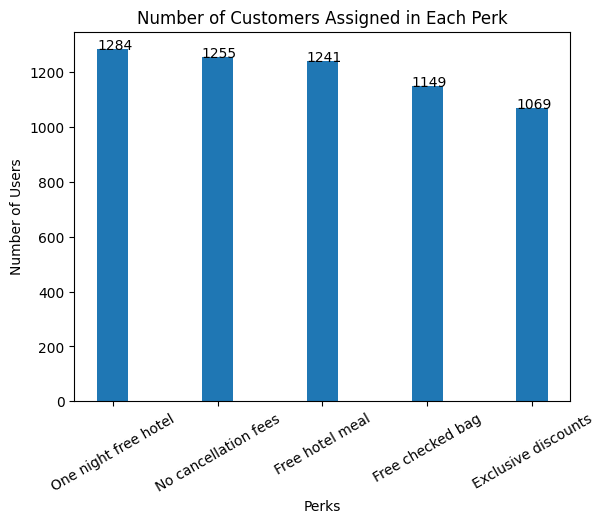

In [ ]:
# Visaualize perks distribution
perk_counts=indexes_rank['Best Perk'].value_counts()

plt.title('Number of Customers Assigned in Each Perk')
plt.xlabel('Perks')
plt.ylabel('Number of Users')

x = perk_counts.index
y = perk_counts.values
bars = plt.bar(x, height=y, width=.3)
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x(), yval + .003, yval)

plt.xticks(rotation=30)
plt.show()

In [ ]:
# backup perks by fuzzy approach to csv file
indexes_rank.to_csv('/content/drive/My Drive/MS-data/Drive/DA205/traveltide-fuzzy-perks.csv', encoding='utf-8', index=False)